Первый тест на размещение.

In [ ]:
from datetime import date

def test_allocating_to_a_batch_reduces_the_available_quantity():
    batch = Batch("batch-001", "SMALL-TABLE", qty=20, eta=date.today())
    line = OrderLine("order-ref", "SMALL-TABLE", 2)
    
    batch.allocate(line)
    
    assert batch.available_quantity == 18
    

Название юнит-теста описывает поведение, которое мы хотим видеть в системе

Модели предметных областей

In [2]:
from datetime import date
from dataclasses import dataclass
from typing import Optional

@dataclass(frozen=True)
class OrderLine:
    '''
    Немутируемый класс данных, без какого-либо поведения.
    '''
    order_id: str
    sku: str
    qty: int
        
        
class Batch:
    def __init__(
        self, ref: str, sku:str, qty: int, eta: Optional[date]
    ):
        self.references = ref
        self.sku = sku
        self.eta = eta
        self.available_quantity = qty
        
    def allocate(self, line: OrderLine):
        self.available_quantity -= line.qty

Здесь реализация тривиальна: класс Batch просто обертывает целочисленное количество available_quantity и мы уменьшаем это значение при размещении.

Давайте напишем несколько неудачных тестов.

In [ ]:
from datetime import date
from domain_model import OrderLine, Batch


def test_allocating_to_a_batch_reduces_the_available_quantity():
    batch = Batch("batch-001", "SMALL-TABLE", qty=20, eta=date.today())
    line = OrderLine("order-ref", "SMALL-TABLE", 2)
    
    batch.allocate(line)
    
    assert batch.available_quantity == 18


def make_batch_and_line(sku, batch_qty, line_qty):
    return (
        Batch("batch-001", sku, batch_qty, eta=date.today()),
        OrderLine("order-123", sku, line_qty)
    )


def test_can_allocate_if_available_greater_than_required():
    large_batch, small_line = make_batch_and_line("ELEGANT_LAMP", 20, 2)
    assert large_batch.allocate(small_line)


def test_can_allocate_if_available_smaller_then_required():
    small_batch, large_line = make_batch_and_line("ELAGANT_LAMP", 2, 20)
    assert small_batch.allocate(large_line) is False


def test_can_allocate_if_available_equal_to_required():
    batch, line = make_batch_and_line("ELEGANT_LAMP", 2, 2)
    assert batch.allocate(line)


def test_cannot_allocate_if_skus_do_not_match():
    batch = Batch("batch-001", "UNCOMFORTABLE_CHAIR", 100, eta=None)
    different_sku_line = OrderLine("order-123", "EXPENSIVE-TOASTER", 10)
    assert batch.allocate(different_sku_line) is False


Тут нет ничего неожиданного. Мы сделали рефакторинг набора тестов,
чтобы не дублировать строки кода для создания партии товара и товарной
позиции заказа для одного и того же артикула, и написали четыре простых
теста для нового метода can_allocate.

In [ ]:
def can_allocate(self, line: OrderLine) -> bool:
    return self.sku == line.sku and self.available_quantity >= line.qty

В этом тесте мы убеждаемся, что отмена размещения товарной позиции
заказа в партии не имеет никакого эффекта в случае, если эта позиция не
была ранее размещена в этой партии. Для этого класс Batch должен по-
нимать, какие товарные позиции заказа были размещены, а какие — нет.

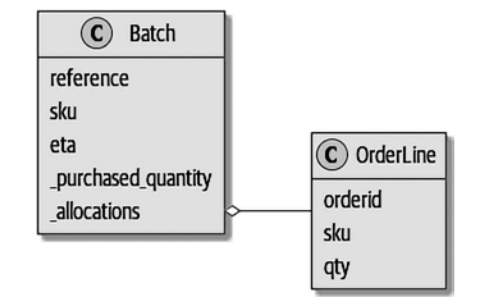

Мы кое-чего добились! Класс Batch теперь отслеживает множество объектов
OrderLine, набор размещенных товарных позиций заказа. В случае если во
время размещения у нас хватает товара, мы просто добавляем в структуру
данных set. Количество available_quantity теперь является вычисляемым
свойством: закупленное количество минус размещенное.

Разумеется, мы могли бы сделать гораздо больше. Немного сбивает с толку,
что и allocate(), и deallocate() могут отказать без уведомления, но зато
у нас есть основа.

Кстати, использование структуры данных set для размещений ._allocations
упрощает нам работу с последним тестом, поскольку элементы во множе-
стве являются уникальными.

In [ ]:
def test_allocation_is_idempotent():
    batch, line = make_batch_and_line("ANGULAR-DESK", 20, 2)
    batch.allocate(line)
    batch.allocate(line)
    assert batch.available_quantity == 18

**Dataclasses (классы данных) отлично подходят для объектов-значений**

В предыдущих листингах мы широко использовали товарную позицию
заказа line буквально, но что такое товарная позиция? Выражаясь деловым языком, заказ состоит из нескольких товарных позиций, у каждой
из которых есть артикул и количество. Скажем, простой файл YAML, содержащий информацию о заказе, мог бы выглядеть так:

Обратите внимание, что, в отличие от заказа, у которого есть уникальная
ссылка для идентификации, товарная позиция указана без такой ссылки.
(Даже если добавить в класс OrderLine ссылку, она не будет однозначно
идентифицировать саму товарную позицию.)
Всякий раз, когда у нас есть концепция, которая имеет данные, но не
идентичность, мы часто выбираем для ее представления паттерн **«Объект-значение»**. **Объект-значение — это любой объект предметной области,
который уникально идентифицируется содержащимися в нем данными;
обычно мы делаем их немутируемыми.**

In [ ]:
@dataclass(frozen=True)
class OrderLine:
    orderid: OrderReference
    sku: ProductReference
    qty: Quantity

Обратите внимание, что, в отличие от заказа, у которого есть уникальная
ссылка для идентификации(order_references), товарная позиция указана без такой ссылки.
(Даже если добавить в класс OrderLine ссылку, она не будет однозначно
идентифицировать саму товарную позицию.)

Всякий раз, когда у нас есть концепция, которая имеет данные, но не
идентичность, мы часто выбираем для ее представления паттерн «Объект-значение».

**Объект-значение — это любой объект предметной области,
который уникально идентифицируется содержащимися в нем данными;
обычно мы делаем их немутируемыми.**

Одна из приятных вещей, которые дают нам dataclasses (или namedtuples), — это эквивалентность значений, причудливый способ сказать, что
«две позиции заказа с одинаковыми orderid, sku и qty идентичны».

In [4]:
from dataclasses import dataclass
from typing import NamedTuple
from collections import namedtuple


@dataclass(frozen=True)
class Name:
    first_name: str
    surname: str
        
        
class Money(NamedTuple):
    currency: str
    value: int
        
        
Line = namedtuple("Line", ['sku', 'qty'])

In [5]:
assert Money('gbp', 10) == Money('gbp', 10)
assert Name('Harry', 'Percival') != Name('Bob', 'Gregory')
assert Line('RED-CHAIR', 5) == Line('RED-CHAIR', 5)

Эти объекты-значения совпадают с нашими интуитивными представлениями
о работе их значений. Совсем не важно, о какой банкноте в 10 фунтов мы го-
ворим, потому что все они имеют одинаковый номинал. Схожим образом два
полных имени эквивалентны, если совпадают имя и фамилия, и две товарных
позиции эквивалентны, если они имеют один и тот же клиентский заказ, код
продукта и количество. 

Вместе с тем объекту-значению по-прежнему можно
задавать сложное поведение. На самом деле широко принято поддерживать
операции со значениями, например математические операторы.

In [9]:
fiver = Money('gbp', 5)
tenner = Money('gbp', 10)


def can_add_money_values_for_the_same_currency():
    assert fiver + fiver == tenner

    
def can_subtract_money_values():
    assert tenner - fiver == fiver

    
def adding_different_currencies_fails():
    with pytest.raises(ValueError):
        Money('usd', 10) + Money('gbp', 10)
        

def can_multiply_money_by_a_number():
    assert fiver * 5 == Money('gbp', 25)

    
def multiplying_two_money_values_is_an_error():
    with pytest.raises(TypeError):
        tenner * fiver

('gbp', 5, 'gbp', 5)


**Объекты значения и сущности**

Товарная позиция имеет уникальные идентификатор, артикул и количество; если мы изменим одно из этих значений, то получим новую товарную позицию. Все дело в определении объекта-значения: это любой объект, который идентифицируется только его данными и не имеет долговременной идентичности. Но как насчет партии? Она идентифицируется по ссылке.

Мы используем термин **«сущность»** для описания объекта предметной области, который имеет долговременную идентичность. На предыдущей странице мы представили класс Name как объект-значение. Если мы возьмем
имя Гарри Персиваль и изменим одну букву, то получим новый объект
класса Name, Барри Персиваль.

In [ ]:
def test_name_equality():
    assert Name("Harry", "Percival") != Name("Barry", "Percival")

Но как насчет Гарри как личности? Люди и правда меняют свои имена,
семейное положение и даже пол, но мы продолжаем признавать в них од-
ного и того же человека. И все потому, что люди, в отличие от имен, имеют
постоянную идентичность.

In [12]:
class Person:
    def __init__(self, name: Name):
        self.name = name
        

def test_barry_is_harry():
    harry = Person(Name("Harry", "Percival"))
    barry = harry
    
    barry.name = Name("Barry", "Percival")
    
    assert harry is barry and barry is harry
    
    
test_barry_is_harry()

Сущности, в отличие от значений, обладают **эквивалентностью идентичности (identity equality)**, или ее **тождественностью**. Мы можем изменить их значения, и они по-прежнему остаются узнаваемо теми же самыми.

Партии в нашем примере являются сущностями. Мы можем разместить товарные позиции заказа в партии или изменить дату, когда она должна прибыть, и это будет все та же самая сущность. В коде обычно мы делаем это явным образом, реализуя для сущностей операторы эквивалентности.

<h2> Не все должно быть объектом: функция службы
предметной области </h2>

Мы создали модель, которая представляет партии товара, но на самом
деле нам нужно размещать товарные позиции заказа в конкретном наборе
партий, образующих все товарные запасы.

*Не все на свете сводится к вещам и предметам.*

Здесь говорится о понятии операций службы предметной области, которые
не входят в сущности или в объекты-значения. То, что размещает товарную
позицию заказа при наличии набора партий, очень смахивает на функцию.

*Службы предметной области — совсем не то же самое, что службы из служебного
слоя, хотя зачастую они тесно связаны. Служба предметной области представляет
бизнес-концепцию или процесс, тогда как служба из служебного слоя представляет
способ использования вашего приложения. Часто служебный слой вызывает службу
предметной области.*

In [ ]:
from datetime import date, timedelta
import pytest
from domain_model import Batch, OrderLine

today = date.today()
tomorrow = today + timedelta(days=1)
later = tomorrow + timedelta(days=10)


def test_prefers_current_stock_batches_to_shipments():
    in_stock_batch = Batch("in-stock-batch", "RETRO-CLOCK", 100, eta=None)
    shipment_batch = Batch("shipment-batch", "RETRO-CLOCK", 100, eta=tomorrow)
    line = OrderLine("oref", "RETRO-CLOCK", 10)

    allocate(line, [in_stock_batch, shipment_batch])

    assert in_stock_batch.available_quantity == 90
    assert shipment_batch.available_quantity == 100


def test_prefers_earlier_batches():
    earliest = Batch("speedy-batch", "MINIMALIST-SPOON", 100, eta=today)
    medium = Batch("normal-batch", "MINIMALIST-SPOON", 100, eta=tomorrow)
    latest = Batch("slow-batch", "MINIMALIST-SPOON", 100, eta=later)
    line = OrderLine("order1", "MINIMALIST-SPOON", 10)

    allocate(line, [medium, earliest, latest])

    assert earliest.available_quantity == 90
    assert medium.available_quantity == 100
    assert latest.available_quantity == 100


def test_returns_allocated_batch_ref():
    in_stock_batch = Batch("in-stock-batch-ref", "HIGHBROW-POSTER", 100, eta=None)
    shipment_batch = Batch("shipment-batch-ref", "HIGHBROW-POSTER", 100, eta=tomorrow)
    line = OrderLine("oref", "HIGHBROW-POSTER", 10)
    allocation = allocate(line, [in_stock_batch, shipment_batch])
    assert allocation == in_stock_batch.reference



Служба:

In [ ]:
def allocate(line: OrderLine, batches: List[Batch]) -> str:
    batch = next(
        b for b in sorted(batches) if b.can_allocate(line)
    )
    batch.allocate(line)
    return batch.reference

**Магические методы Python позволяют использовать модели вместе с идиомами Python**

Чтобы всё работало корректно(sorted), в модели предметной области реализуем магический метод __ gt __

In [ ]:
class Batch:
    ...
    
    def __gt__(self, other):
        if self.eta is None:
            return False
        if other.eta is None:
            return True
        return self.eta > other.eta

**Исключения тоже могут выражать понятия предметной области**

Осталось разобраться с последней концепцией: исключения тоже могут
использоваться для выражения понятий предметной области. В наших
беседах с экспертами мы узнали, что заказ нельзя разместить, если товара
нет в наличии, и мы можем охватить это, инициировав соответствующее
**исключение из предметной области**.

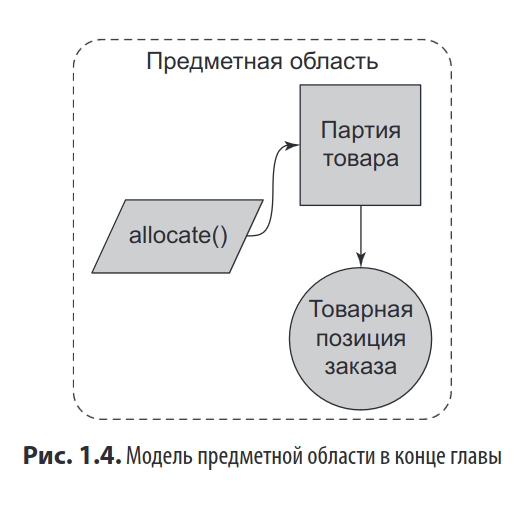